The purpose of this project is to make a model predicting whether a kickstarter project will be success or fail.

## 1 Some Preparation

In [17]:
import pandas as pd
import os
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
os.listdir('kickstarter-projects')

['ks-projects-201801.csv', 'ks-projects-201612.csv']

In [3]:
# load one dataset and preview
df = pd.read_csv("kickstarter-projects/ks-projects-201801.csv",parse_dates=True)
df.head(3)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00


## 2 Exploration Analysis

We summarize the portion of each kind of state, there are 38779 'canceled' and 197719 'failed' projects, 133956 successful projects. If we treat 'canceled' and 'failed'as failed state, the quantity of failed case is more than successful cases. Therefore, there may be unbanlance between two outcomes.

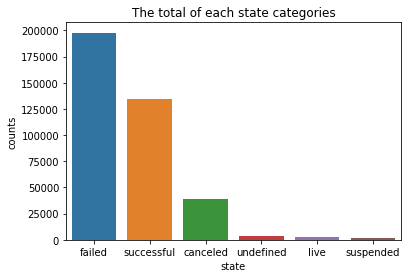

In [19]:
# use seaborn to plot the pivot of states' counts
state_pv = pd.pivot_table(df,index=['state'],values=['ID'],aggfunc=len).sort_values(by='ID',ascending=False)
sns.barplot(x=state_pv.index,y='ID',data=state_pv)
plt.title("The total of each state categories")
plt.ylabel("counts")


From the below graph, we can guess, the successful projects usually set a goal of little money. The failed and canceled projects are more likely to have a higher goal. A too high amount money goal may effect the project hit the achieve line.

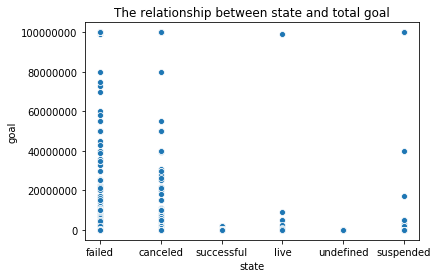

In [20]:
# plot two columns: state and goal
sns.scatterplot(x='state',y='goal',data=df)
plt.title("The relationship between state and total goal")
plt.ticklabel_format(style='plain', axis='y')

Backers are the number of people support the project. It appears that the most successful projects have larger number of backers than projects in other state.

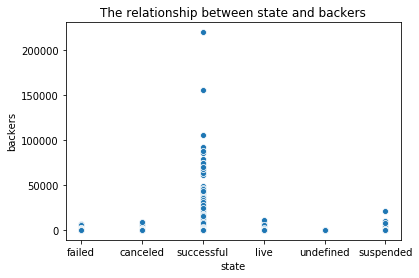

In [21]:
# plot two columns: state and backers
sns.scatterplot(x='state',y='backers',data=df)
plt.title("The relationship between state and backers")
plt.ticklabel_format(style='plain', axis='y')

The amount of money pledged in successful projects also higher than other kinds ouptcome projects.

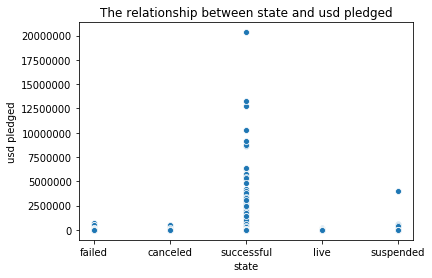

In [22]:
# plot two columns: state and usd pledged
sns.scatterplot(x='state',y='usd pledged',data=df)
plt.title("The relationship between state and usd pledged")
plt.ticklabel_format(style='plain', axis='y')

## 3 Feature engineer and more preparation 

In [24]:
features = df[['deadline','goal','launched','state','backers','usd pledged']]

In [25]:
# in order to simplify the problem, we rule out 
# the state of undefined, suspended and live. 
# We also assume canceled as fail.
features = (
    features.dropna()
            .query('(state == "failed") or (state == "canceled") or (state == "successful")')
)

In [26]:
features.head()

,deadline,goal,launched,state,backers,usd pledged
0,2015-10-09,1000.0,2015-08-11 12:12:28,failed,0,0.0
1,2017-11-01,30000.0,2017-09-02 04:43:57,failed,15,100.0
2,2013-02-26,45000.0,2013-01-12 00:20:50,failed,3,220.0
3,2012-04-16,5000.0,2012-03-17 03:24:11,failed,1,1.0
4,2015-08-29,19500.0,2015-07-04 08:35:03,canceled,14,1283.0


In [27]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 370222 entries, 0 to 378660
Data columns (total 6 columns):
deadline       370222 non-null object
goal           370222 non-null float64
launched       370222 non-null object
state          370222 non-null object
backers        370222 non-null int64
usd pledged    370222 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 19.8+ MB


In [28]:
features['deadline'] = pd.to_datetime(features['deadline']) 
features['launched'] = pd.to_datetime(features['launched']) 
features['diff'] = features['deadline'] - features['launched']

# convert the time delta to numeric days
def tointerval(r):
    return pd.Timedelta(r).days


features['time'] = features['diff'].apply(tointerval)

In [29]:
# convert the state to numeric
def gen_result(r):
    if r == 'successful':
        return 1
    else:
        return 0

# make new column based on state condition
features['result'] = features['state'].apply(gen_result)

The successful projects does not different paticularly with other states, but the canceled one have more days between their launch and end.

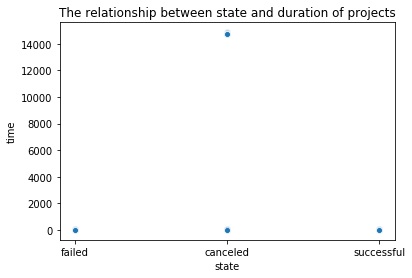

In [31]:
# plot two columns: state and time span
sns.scatterplot(x='state',y='time',data=features)
plt.title("The relationship between state and duration of projects")
plt.ticklabel_format(style='plain', axis='y')

In [11]:
model_val = features[['result','time','goal','backers','usd pledged']]
model_val.describe()

,result,time,goal,backers,usd pledged
count,370222.000000,370222.000000,3.702220e+05,370222.000000,3.702220e+05
mean,0.361543,33.407807,4.865949e+04,106.986149,7.076438e+03
std,0.480448,60.707461,1.160225e+06,915.261802,7.882258e+04
min,0.000000,0.000000,1.000000e-02,0.000000,0.000000e+00
25%,0.000000,29.000000,2.000000e+03,2.000000,1.900000e+01
50%,0.000000,29.000000,5.500000e+03,12.000000,4.026250e+02
75%,1.000000,36.000000,1.650000e+04,57.000000,3.065000e+03
max,1.000000,14866.000000,1.000000e+08,219382.000000,2.033899e+07


## 4 Modeling and evaluation

In [12]:
import sklearn as sk
from sklearn import preprocessing

# shuffle the sample
model_val = sk.utils.shuffle(model_val)

# assign X exculde the result, nparray
X = model_val.drop("result",axis=1).values
# assign y as column 'result'
y = model_val["result"].values

# normalize features
# y is 0,1s, not need to normalize
X = preprocessing.normalize(X)

# we take around 20% of samples as test dataset
test = 74000
X_trian = X[:-test]
y_trian = y[:-test]

X_test = X[-test:]
y_test = y[-test:]

### Support Vector Machine
We first fit the model by SVM

In [13]:
# from sklearn import svm

# clf = svm.SVC()
# clf.fit(X_trian,y_trian)

In [14]:
# clf.score(X_test,y_test)

### Logistic Regression

In [27]:
from sklearn.linear_model import LogisticRegression

lg_clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
lg_clf.fit(X_trian, y_trian)
lg_clf.score(X_test,y_test)

0.9485

### KNeighbors

In [15]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(X_trian, y_trian) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=10, p=2,
           weights='uniform')

In [16]:
neigh.score(X_test,y_test)

0.9647297297297297

In [17]:
# cross valide the model
from sklearn.model_selection import cross_val_score

score = cross_val_score(neigh,X_test,y_test,cv=5)
print(score.mean(),score.std() *2)
print(score)

0.9636621621621622 0.0016647420102091186
[0.965      0.96290541 0.96425676 0.96324324 0.96290541]


In [18]:
y_predict = neigh.predict(X_test)

In [19]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test,y_predict).ravel()
(tn, fp, fn, tp)

(46243, 997, 1613, 25147)

Accroding to the following confusion metrix, there are 2592 instance classified in wrong output. And the model predict more success case into fail one.

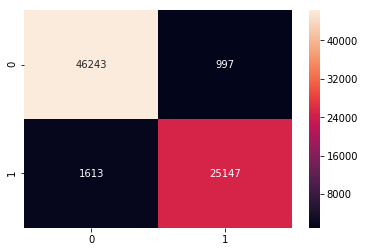

In [20]:
kneigbor_metrix = metrics.confusion_matrix(y_test,y_predict)
df_kn_metrix = pd.DataFrame(kneigbor_metrix,range(2),range(2))
sns.heatmap(df_kn_metrix,annot=True,fmt='g')

Text(0.5, 0, 'False Positive Rate')

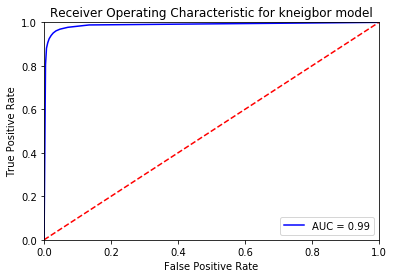

In [21]:

proba = neigh.predict_proba(X_test)
preds = proba[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test,preds)
roc_auc = metrics.auc(fpr,tpr)

plt.title("Receiver Operating Characteristic for kneigbor model")
plt.plot(fpr,tpr,'b', label=f'AUC = {roc_auc:.2f}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [ ]:
# TODO use the precision for ROC plot to consider if the result influenced by imbalance data
# metrics.precision_recall_curve(y_test,preds)

### Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier

rfclf = RandomForestClassifier(n_estimators=10)
rfclf.fit(X_trian, y_trian) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [23]:
rfclf.score(X_test,y_test)

0.9620405405405406

In [24]:
rfscore = cross_val_score(rfclf,X_test,y_test,cv=10)
print(rfscore.mean(),rfscore.std() *2)
print(rfscore)

0.9615945945945945 0.002617020202575178
[0.96216216 0.9627027  0.96148649 0.96256757 0.96189189 0.96
 0.95986486 0.96418919 0.96067568 0.96040541]


In [25]:
# TODO complete all evaluation
# TODO Optimation
# TODO 预测2016年数据，评价准确性
# TODO Save models